# Дорогой дневник

--------------------------------------------

1) Сначала я решил попробовать без генерации новых фичей и без подкрутки параметров запустить LightGBM и посмотреть, что будет. Скор 0.720
При этом пока еще нет ни генерации новых признаков, ни использования таблицы поиска и тд. Попробуем добавить.

2) Просто запускаем код из "baseline_1_pandas.ipynb" и получаем обещаный скор 0.817

3) Оптюнил 10 минут, безрезультатно. Буду придумывать новые признаки. Думаю начать с кластеризации и knn. 

4) Сначала решил просто расширить плавающее окно с 4 до 5 месяцев, результат 0.8192.

    Есть огромное количество идей, только что заменил пандас на поларс, потому что он реально на порядок быстрее. В первую очередь хочется применить знания с семинара по интерпретации бустингов, но сначала заменить катбуст на lgbm, ибо Илья утверждал, что при должном обращении он рвет и мечет.

--------------------------------------------

In [2]:
import polars as pl
import pandas as pd
import numpy as np
import catboost
import os
from datetime import date, timedelta
from local_utils import *
import lightgbm as lgb

%load_ext autoreload
%autoreload 2


In [ ]:
test_start_date = date(2024, 8, 1)
val_start_date = date(2024, 7, 1)
val_end_date = date(2024, 7, 31)
train_end_date = date(2024, 6, 30)
data_path = "C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2"

# Read data

In [108]:
actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet')).collect()
search_history = pl.scan_parquet(os.path.join(data_path, 'search_history/*.parquet')).collect()
product_information = pl.read_csv(
    os.path.join(data_path, 'product_information.csv'),
    ignore_errors=True
)

In [109]:
pl.read_csv(os.path.join(data_path, 'action_type_info.csv'))

shape: (6, 2)
┌─────────────┬────────────────┐
│ action_type ┆ action_type_id │
│ ---         ┆ ---            │
│ str         ┆ i64            │
╞═════════════╪════════════════╡
│ click       ┆ 1              │
│ favorite    ┆ 2              │
│ order       ┆ 3              │
│ search      ┆ 4              │
│ to_cart     ┆ 5              │
│ view        ┆ 6              │
└─────────────┴────────────────┘

In [ ]:
val_target = (
    actions_history
    .filter(pl.col('timestamp').dt.date() >= val_start_date)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .select('user_id', (pl.col('action_type_id') == 3).alias('has_order'))
    .group_by('user_id')
    .agg(pl.max('has_order').cast(pl.Int32).alias('target'))
)

In [ ]:
val_target.group_by('target').agg(pl.count('user_id'))

shape: (2, 2)
┌────────┬─────────┐
│ target ┆ user_id │
│ ---    ┆ ---     │
│ i32    ┆ u32     │
╞════════╪═════════╡
│ 0      ┆ 1227381 │
│ 1      ┆ 647575  │
└────────┴─────────┘

# Simple pipeline

## Feats

In [112]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite",
    3: "order",
    5: "to_cart",
}
for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 4))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information
            .select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
        .select(
            'user_id',
            f'num_products_{suf}',
            f'sum_discount_price_{suf}',
            f'max_discount_price_{suf}',
            f'days_since_last_{suf}',
            f'days_since_first_{suf}',
        )
    )
    actions_aggs[id_] = aggs

In [ ]:
# search_aggs
id_ = 4
suf = 'search'
actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 4))
    .group_by('user_id')
    .agg(
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .with_columns([
        (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
        .dt.total_days()
        .cast(pl.Int32)
        .alias(f'days_since_last_{suf}'),

        (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
        .dt.total_days()
        .cast(pl.Int32)
        .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    )
)

In [114]:
actions_aggs.keys()

dict_keys([1, 2, 3, 5, 4])

In [115]:
df = val_target
for _, actions_aggs_df in actions_aggs.items():
    df = (
        df
        .join(actions_aggs_df, on='user_id', how='left')
    )

In [116]:
df

shape: (1_874_956, 25)
┌─────────┬────────┬────────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ user_id ┆ target ┆ num_produc ┆ sum_discou ┆ … ┆ days_since ┆ num_search ┆ days_sinc ┆ days_sinc │
│ ---     ┆ ---    ┆ ts_click   ┆ nt_price_c ┆   ┆ _first_to_ ┆ ---        ┆ e_last_se ┆ e_first_s │
│ i32     ┆ i32    ┆ ---        ┆ lick       ┆   ┆ cart       ┆ i32        ┆ arch      ┆ earch     │
│         ┆        ┆ i32        ┆ ---        ┆   ┆ ---        ┆            ┆ ---       ┆ ---       │
│         ┆        ┆            ┆ f32        ┆   ┆ i32        ┆            ┆ i32       ┆ i32       │
╞═════════╪════════╪════════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 4414649 ┆ 0      ┆ 20         ┆ 13833.0    ┆ … ┆ 45         ┆ 9          ┆ 1         ┆ 96        │
│ 6600543 ┆ 0      ┆ null       ┆ null       ┆ … ┆ null       ┆ null       ┆ null      ┆ null      │
│ 4584152 ┆ 0      ┆ null       ┆ null       ┆ … ┆ null       ┆ null       ┆ null      ┆ null      │
│ 8989878 ┆ 0      ┆ null       ┆ null       ┆ … ┆ null       ┆ null       ┆ null      ┆ null      │
│ 2988255 ┆ 0      ┆ null       ┆ null       ┆ … ┆ null       ┆ null       ┆ null      ┆ null      │
│ …       ┆ …      ┆ …          ┆ …          ┆ … ┆ …          ┆ …          ┆ …         ┆ …         │
│ 882807  ┆ 0      ┆ null       ┆ null       ┆ … ┆ null       ┆ null       ┆ null      ┆ null      │
│ 6396959 ┆ 0      ┆ null       ┆ null       ┆ … ┆ null       ┆ null       ┆ null      ┆ null      │
│ 4808258 ┆ 0      ┆ 13         ┆ 2317.0     ┆ … ┆ null       ┆ 7          ┆ 58        ┆ 58        │
│ 7021933 ┆ 1      ┆ 47         ┆ 13535.0    ┆ … ┆ 116        ┆ 98         ┆ 7         ┆ 116       │
│ 8493454 ┆ 0      ┆ 14         ┆ 5998.0     ┆ … ┆ 114        ┆ 40         ┆ 18        ┆ 115       │
└─────────┴────────┴────────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

In [117]:
df_pd = df.to_pandas()

In [118]:
tr, val = get_split(df_pd, val_size=0.3)

In [119]:
df_pd.columns

Index(['user_id', 'target', 'num_products_click', 'sum_discount_price_click',
       'max_discount_price_click', 'days_since_last_click',
       'days_since_first_click', 'num_products_favorite',
       'sum_discount_price_favorite', 'max_discount_price_favorite',
       'days_since_last_favorite', 'days_since_first_favorite',
       'num_products_order', 'sum_discount_price_order',
       'max_discount_price_order', 'days_since_last_order',
       'days_since_first_order', 'num_products_to_cart',
       'sum_discount_price_to_cart', 'max_discount_price_to_cart',
       'days_since_last_to_cart', 'days_since_first_to_cart', 'num_search',
       'days_since_last_search', 'days_since_first_search'],
      dtype='object')

In [120]:
cols = [
    'num_products_click', 
    'sum_discount_price_click', 'max_discount_price_click',
    'days_since_last_click', 'days_since_first_click',
    'num_products_favorite', 'sum_discount_price_favorite',
    'max_discount_price_favorite', 'days_since_last_favorite',
    'days_since_first_favorite', 'num_products_order',
    'sum_discount_price_order', 'max_discount_price_order',
    'days_since_last_order', 'days_since_first_order',
    'num_products_to_cart', 'sum_discount_price_to_cart',
    'max_discount_price_to_cart', 'days_since_last_to_cart',
    'days_since_first_to_cart', 'num_search', 'days_since_last_search',
    'days_since_first_search'
]

In [ ]:
model = train_model(
    tr,
    val,
    features=cols,
    target_col='target',
    params={
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.1,
        'max_depth': 7,
        'num_iterations': 200,
        'early_stopping_rounds': 50,
        'verbose': 10
    }
)

[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=7) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=128) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=7) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=128) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Number of positive: 453534, number of negative: 858935
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.838965
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.345107
[LightGBM] [Debug] init for col-wise cost 0.013558 seconds, init for row-wise cost 0.065524 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the over

In [122]:
name = 'baseline_1_lgb'
model.save_model(f"{name}.txt")

In [123]:
fi = pd.DataFrame({
    'feature': model.feature_name(),
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

fi.head(50)

feature    importance
13        days_since_last_order  1.230845e+06
16   sum_discount_price_to_cart  1.898710e+05
10           num_products_order  1.020412e+05
11     sum_discount_price_order  6.157804e+04
20                   num_search  2.331626e+04
17   max_discount_price_to_cart  2.301537e+04
14       days_since_first_order  2.197040e+04
15         num_products_to_cart  1.885469e+04
0            num_products_click  1.862233e+04
22      days_since_first_search  1.134987e+04
12     max_discount_price_order  9.075236e+03
19     days_since_first_to_cart  8.160422e+03
18      days_since_last_to_cart  7.847186e+03
21       days_since_last_search  6.909388e+03
3         days_since_last_click  6.644068e+03
2      max_discount_price_click  4.412023e+03
4        days_since_first_click  3.889578e+03
1      sum_discount_price_click  3.768211e+03
5         num_products_favorite  2.654500e+03
7   max_discount_price_favorite  2.486835e+03
9     days_since_first_favorite  2.437259e+03
8      days_since_last_favorite  2.090983e+03
6   sum_discount_price_favorite  1.244373e+03

In [124]:
test_users_submission = (
    pl.read_csv(os.path.join(data_path, 'test_users.csv'))
)

In [125]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite",
    3: "order",
    5: "to_cart",
}
for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= val_end_date)
        .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 4))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information
            .select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
        .select(
            'user_id',
            f'num_products_{suf}',
            f'sum_discount_price_{suf}',
            f'max_discount_price_{suf}',
            f'days_since_last_{suf}',
            f'days_since_first_{suf}',
        )
    )
    actions_aggs[id_] = aggs

In [126]:
# search_aggs
id_ = 4
suf = 'search'
actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 4))
    .group_by('user_id')
    .agg(
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .with_columns([
        (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
        .dt.total_days()
        .cast(pl.Int32)
        .alias(f'days_since_last_{suf}'),

        (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
        .dt.total_days()
        .cast(pl.Int32)
        .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    )
)

In [127]:
df = test_users_submission
for _, actions_aggs_df in actions_aggs.items():
    df = (
        df
        .join(actions_aggs_df, on='user_id', how='left')
    )

In [128]:
df_pd = df.to_pandas()

In [129]:
df_pd.shape

(2068424, 24)

In [130]:
df_pd['predict'] = model.predict(df_pd[cols])

In [131]:
df_pd[['user_id', 'predict']]

user_id   predict
0            1342  0.187895
1            9852  0.797921
2           10206  0.223718
3           11317  0.216140
4           13289  0.600491
...           ...       ...
2068419  11157283  0.224649
2068420  11160395  0.139401
2068421  11165052  0.570314
2068422  11168218  0.498980
2068423  11172313  0.506017

[2068424 rows x 2 columns]

In [132]:
df_pd[['user_id', 'predict']].to_csv('baseline_1_submission.csv', index=False)

In [135]:
tr[cols].head(10)

num_products_click  sum_discount_price_click  max_discount_price_click  \
0                12.0                    4795.0                    1021.0   
1                 NaN                       NaN                       NaN   
2                 NaN                       NaN                       NaN   
3                 2.0                     797.0                     449.0   
4                 NaN                       NaN                       NaN   
5                 NaN                       NaN                       NaN   
6                 NaN                       NaN                       NaN   
7                 3.0                    3341.0                    2565.0   
8                 NaN                       NaN                       NaN   
9                15.0                    5894.0                     792.0   

   days_since_last_click  days_since_first_click  num_products_favorite  \
0                   59.0                   101.0                    NaN   
1                    NaN                     NaN                    NaN   
2                    NaN                     NaN                    NaN   
3                   62.0                   107.0                    NaN   
4                    NaN                     NaN                    NaN   
5                    NaN                     NaN                    NaN   
6                    NaN                     NaN                    NaN   
7                   17.0                   107.0                    NaN   
8                    NaN                     NaN                    NaN   
9                   39.0                    49.0                    4.0   

   sum_discount_price_favorite  max_discount_price_favorite  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          NaN                          NaN   
3                          NaN                          NaN   
4                          NaN                          NaN   
5                          NaN                          NaN   
6                          NaN                          NaN   
7                          NaN                          NaN   
8                          NaN                          NaN   
9                       2448.0                        744.0   

   days_since_last_favorite  days_since_first_favorite  ...  \
0                       NaN                        NaN  ...   
1                       NaN                        NaN  ...   
2                       NaN                        NaN  ...   
3                       NaN                        NaN  ...   
4                       NaN                        NaN  ...   
5                       NaN                        NaN  ...   
6                       NaN                        NaN  ...   
7                       NaN                        NaN  ...   
8                       NaN                        NaN  ...   
9                      49.0                       49.0  ...   

   days_since_last_order  days_since_first_order  num_products_to_cart  \
0                    NaN                     NaN                   8.0   
1                    NaN                     NaN                   NaN   
2                    NaN                     NaN                   NaN   
3                    NaN                     NaN                   3.0   
4                    NaN                     NaN                   NaN   
5                    NaN                     NaN                   NaN   
6                    NaN                     NaN                   NaN   
7                    NaN                     NaN                   4.0   
8                    NaN                     NaN                   NaN   
9                    NaN                     NaN                   5.0   

   sum_discount_price_to_cart  max_discount_price_to_cart  \
0                      2267.0                       499.0   
1   

In [137]:
tr[cols].nunique()

num_products_click               1125
sum_discount_price_click       103251
max_discount_price_click         8759
days_since_last_click             121
days_since_first_click            122
num_products_favorite             380
sum_discount_price_favorite     21677
max_discount_price_favorite      5431
days_since_last_favorite          121
days_since_first_favorite         121
num_products_order                925
sum_discount_price_order        43575
max_discount_price_order         4734
days_since_last_order             121
days_since_first_order            121
num_products_to_cart             1339
sum_discount_price_to_cart      83447
max_discount_price_to_cart       5697
days_since_last_to_cart           121
days_since_first_to_cart          122
num_search                       1155
days_since_last_search            121
days_since_first_search           122
dtype: int64

In [165]:
from IPython.display import display

display(get_df_info_new(tr[cols]).style.bar(subset=['nunique'], cmap="bwr"))

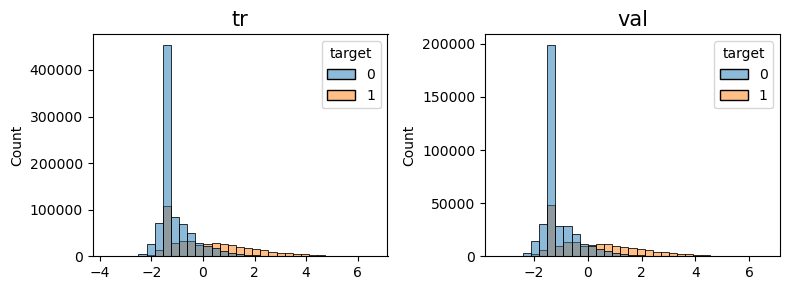

In [156]:
plot_scores(model, tr[cols], tr.target, val[cols], val.target)

In [ ]:
#plot_scores(model, tr[cols], tr.target, val[cols], val.target, split_col='days_since_last_order')

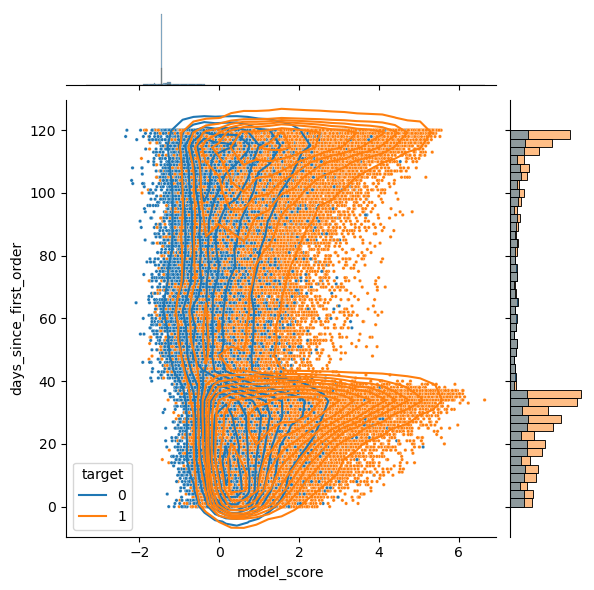

In [166]:
plot_scores(model, tr[cols], tr.target, val[cols], val.target, support_col='days_since_first_order', support_log=False)

Вывод такой - Опираясь на количество дней с первого заказа часто лишний раз говорим, что таргет у пользователя 1, хотя на самом деле 0

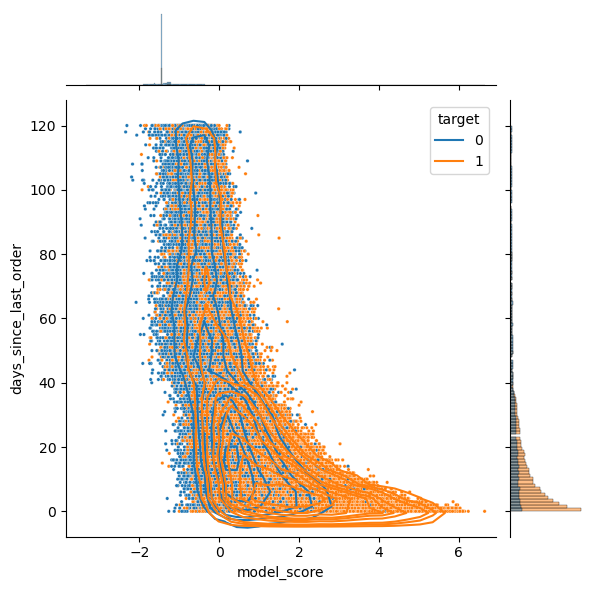

In [167]:
plot_scores(model, tr[cols], tr.target, val[cols], val.target, support_col='days_since_last_order', support_log=False)

Нужно понимать так: начиная где то с 3 оранжевые отлично отделяются от синих, это супер. А вот левее каша, нам нехватает фичей. 

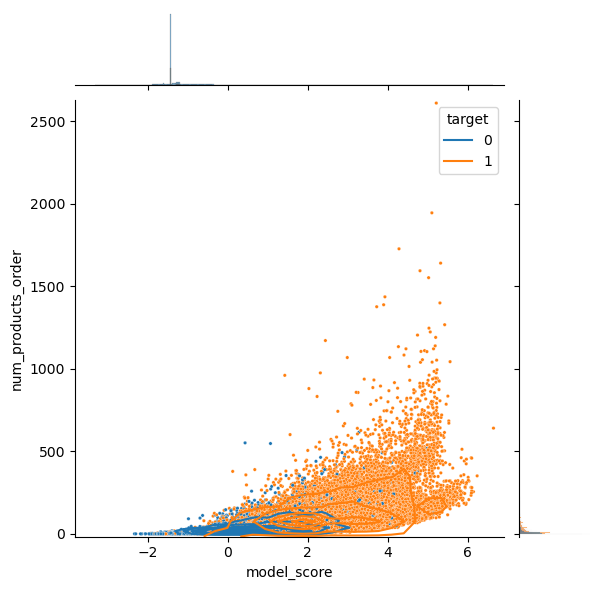

In [168]:
plot_scores(model, tr[cols], tr.target, val[cols], val.target, support_col='num_products_order', support_log=False)

Очень плохо видно, но похоже что все +- неормально

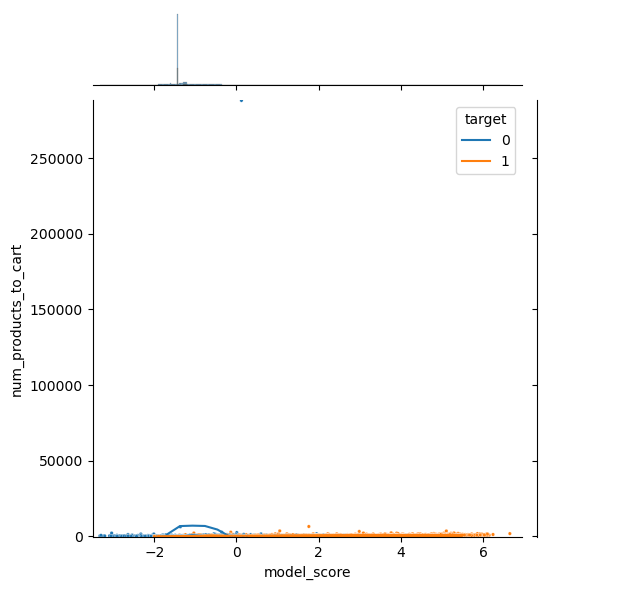

In [169]:
plot_scores(model, tr[cols], tr.target, val[cols], val.target, support_col='num_products_to_cart', support_log=False)

Есть жесткий выбрас, нужно посмотреть что не так

In [172]:
params={
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.1,
        'max_depth': 7,
        'num_iterations': 200,
        'early_stopping_rounds': 50,
        'verbose': 10,
        'importance_type': 'split'
    }

model_with_rnd, shadow_features, tr_rnd, val_rnd = train_model(tr, val, cols, 'target', params=params, shadow_features=True, sklearn_style=True)
rnd_features = np.r_[cols, shadow_features]
shadow_features

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Number of positive: 453534, number of negative: 858935
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.838965
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.242445
[LightGBM] [Debug] init for col-wise cost 0.012586 seconds, init for row-wise cost 0.065742 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 6711
[LightGBM] [Info] Number of data points in the train set: 1312469, number of used features: 38
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[L

Index(['shadow_float_1', 'shadow_float_2', 'shadow_float_3', 'shadow_float_4',
       'shadow_float_5', 'shadow_cat_big_1', 'shadow_cat_big_2',
       'shadow_cat_big_3', 'shadow_cat_big_4', 'shadow_cat_big_5',
       'shadow_cat_small_1', 'shadow_cat_small_2', 'shadow_cat_small_3',
       'shadow_cat_small_4', 'shadow_cat_small_5'],
      dtype='object')

feature_importance: [ 68   6  10  24  12  17   0   9   6   6  62  66  26 111  85  27  59  23
  17  25  66  24  31   0   0   0   0   0 181 153 185 168 153   0   0   0
   0   0] 



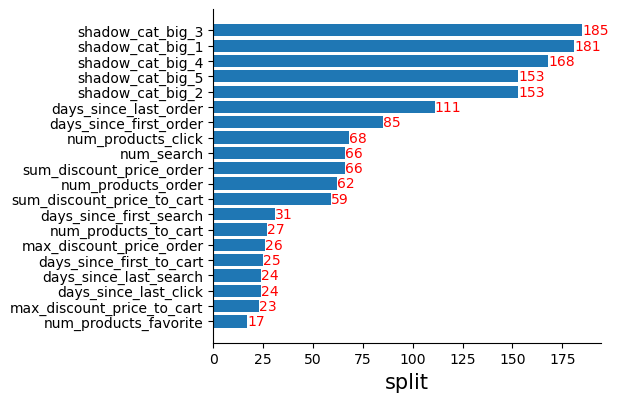

In [173]:
from local_utils import *

print('feature_importance:', model_with_rnd.feature_importances_, '\n')

plot_lgbm_importance(model_with_rnd, rnd_features, importance_type='split', top_k=20, sklearn_style=True)

Видим что фейк фичи все забили

CPU times: total: 5min 36s
Wall time: 1min 14s


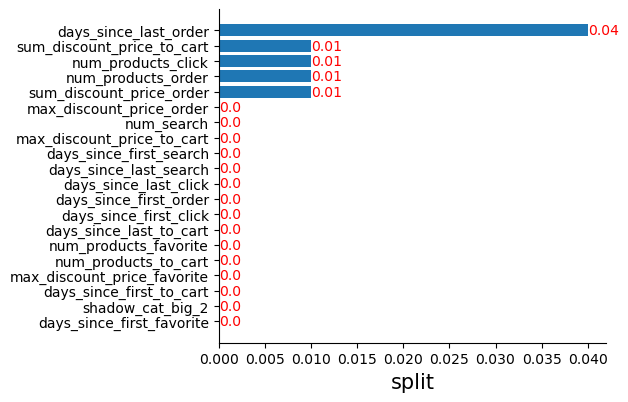

In [ ]:
%%time
from sklearn.inspection import permutation_importance


importance_dict = permutation_importance(model_with_rnd, val_rnd[rnd_features], val.target, scoring='roc_auc')
plot_lgbm_importance(model_with_rnd, rnd_features, importance_type='split', top_k=20, sklearn_style=True,
,                     imps=importance_dict['importances_mean'], round_to=2)

Более честная важность с перемешкой элементов внутри фичи - интересно что модель не прислушалась к фейк фичам, значит она вполне надежная и не есть что попало. 

А еще это значит что наши фичи вполне адекватные, пока что.

In [176]:
model_cb = train_cb_model(tr, val, cols, 'target')
model_cb.save_model('cb_model.json', format='json')
import json

t = json.load(open('cb_model.json', 'r'))['oblivious_trees']
t

0:	test: 0.7446685	best: 0.7446685 (0)	total: 87.7ms	remaining: 43.7s
499:	test: 0.7573904	best: 0.7573916 (498)	total: 44.8s	remaining: 0us

bestTest = 0.7573915725
bestIteration = 498

Shrink model to first 499 iterations.


[{'leaf_values': [-0.014526871418455543,
   0.004825445969042904,
   0,
   0,
   0,
   0,
   0,
   0,
   -0.009793339416372822,
   0.006475191615488805,
   -0.011625981181844587,
   0.01676889628492089,
   0,
   0,
   0,
   0,
   -0.01738750419881078,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   -0.006371455256331234,
   0.011239188180447635,
   -0.005287254582960799,
   0.025518871772933965,
   0,
   0,
   0,
   0,
   -0.0017051276409877894,
   0.0028817310451924555,
   0,
   0,
   -0.00484844454917292,
   -0.0017165544662303908,
   0,
   0,
   -0.0005756036201069067,
   0.003425288852269286,
   -0.0006251705456305805,
   0.01026579237727808,
   -0.006156480831244444,
   -0.003070176175389998,
   -0.008504518145186097,
   -0.000363676432103119,
   -0.006928385818361476,
   -0.0029375699099448496,
   0,
   0,
   -0.011243850682856058,
   -0.005299911848249969,
   0,
   0,
   0.0023474909187060143,
   0.006831322403083658,
   0.008369534585560492,
   0.017186475123972957,
   -0.00272297

In [177]:
t = model_with_rnd.booster_.trees_to_dataframe()
t

tree_index  node_depth node_index left_child right_child parent_index  \
0              0           1       0-S0       0-S1        0-S2         None   
1              0           2       0-S1       0-S5        0-S3         0-S0   
2              0           3       0-S5      0-S10        0-S9         0-S1   
3              0           4      0-S10      0-S22       0-L11         0-S5   
4              0           5      0-S22       0-L0       0-L23        0-S10   
...          ...         ...        ...        ...         ...          ...   
3289          53           5      53-L2       None        None        53-S4   
3290          53           5      53-S5      53-L5       53-L6        53-S4   
3291          53           6      53-L5       None        None        53-S5   
3292          53           6      53-L6       None        None        53-S5   
3293          53           4      53-L4       None        None        53-S3   

                   split_feature     split_gain  \
0          days_since_last_order  246037.000000   
1     sum_discount_price_to_cart   18762.500000   
2             num_products_order    2280.449951   
3     sum_discount_price_to_cart     649.765991   
4       sum_discount_price_order     261.221008   
...                          ...            ...   
3289                        None            NaN   
3290            shadow_cat_big_1      61.100601   
3291                        None            NaN   
3292                        None            NaN   
3293                        None            NaN   

                                              threshold decision_type  \
0                                                  40.5            <=   
1                                               10953.5            <=   
2                                                   7.5            <=   
3                                                3961.5            <=   
4                                                1075.5            <=   
...                                                 ...           ...   
3289                                               None          None   
3290  12||14||15||24||28||29||37||41||44||46||48||51...            ==   
3291                                               None          None   
3292                                               None          None   
3293                                               None          None   

     missing_direction missing_type     value         weight    count  
0                right          NaN -0.638623  296812.000000  1312469  
1                 left          NaN -0.470351   67214.000000   297213  
2                 left          NaN -0.527061   31231.900000   138104  
3                 left          NaN -0.549993   18155.800000    80283  
4                 left          NaN -0.562608   12567.300000    55571  
...                ...          ...       ...            ...      ...  
3289              None         None -0.138643      26.626176      401  
3290             right          NaN  0.010683     113.709000     1935  
3291              None         None -0.104336      24.781586      394  
3292              None         None  0.050042      88.927569     1541  
3293              None         None  0.047673     706.279592    12436  

[3294 rows x 15 columns]

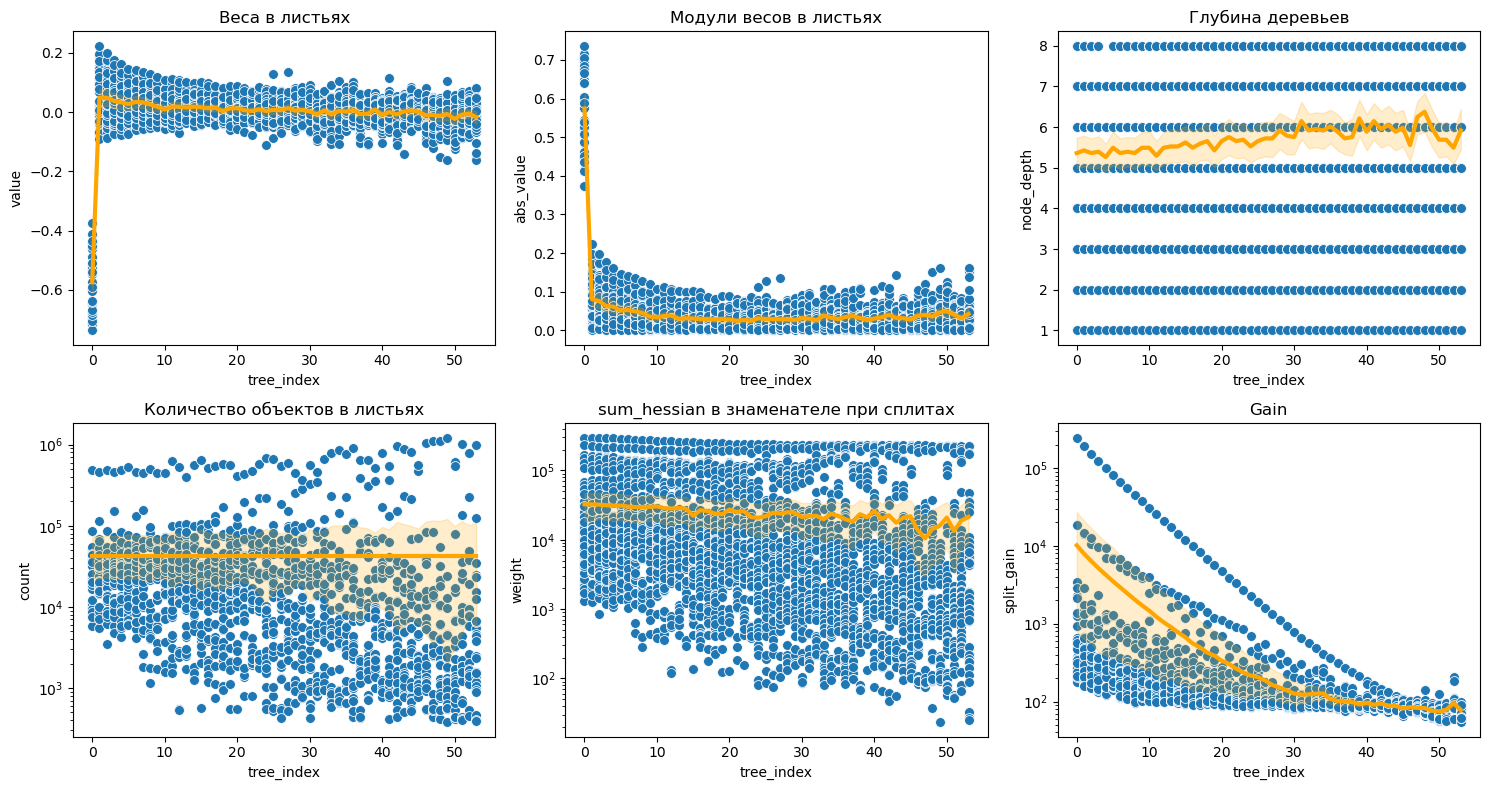

In [178]:
plot_ensemble_profile(t)

In [183]:
t.query('node_depth == 1').sample(15)

tree_index  node_depth node_index left_child right_child parent_index  \
122            2           1       2-S0       2-S2        2-S1         None   
854           14           1      14-S0      14-S1       14-S2         None   
1525          25           1      25-S0      25-S2       25-S1         None   
1098          18           1      18-S0      18-S1       18-S2         None   
2745          45           1      45-S0      45-S1      45-S13         None   
2135          35           1      35-S0      35-S1       35-S2         None   
2684          44           1      44-S0      44-S1       44-S2         None   
3172          52           1      52-S0      52-S1       52-S2         None   
1647          27           1      27-S0      27-S2       27-S1         None   
61             1           1       1-S0       1-S2        1-S1         None   
3111          51           1      51-S0      51-S1      51-S23         None   
671           11           1      11-S0      11-S1       11-S2         None   
1952          32           1      32-S0      32-S2       32-S1         None   
244            4           1       4-S0       4-S2        4-S1         None   
1159          19           1      19-S0      19-S2       19-S1         None   

                 split_feature     split_gain threshold decision_type  \
122      days_since_last_order  153544.000000      44.5            <=   
854      days_since_last_order   14413.599609      33.5            <=   
1525        num_products_order    1900.069946       9.5            <=   
1098     days_since_last_order    6809.279785      27.5            <=   
2745        num_products_order     107.992996     170.5            <=   
2135     days_since_last_order     360.811005       6.5            <=   
2684    days_since_last_search     117.483002       2.5            <=   
3172                num_search      59.607899      51.5            <=   
1647  sum_discount_price_order    1328.060059    3777.5            <=   
61       days_since_last_order  192779.000000      47.5            <=   
3111     days_since_last_order      63.652000       5.5            <=   
671      days_since_last_order   25436.599609      37.5            <=   
1952        num_products_order     571.869019      21.5            <=   
244      days_since_last_order  100322.000000      40.5            <=   
1159        num_products_order    5649.720215       4.5            <=   

     missing_direction missing_type         value    weight    count  \
122              right          NaN -2.294680e-04  294486.0  1312469   
854              right          NaN -1.059680e-04  256484.0  1312469   
1525              left          NaN -6.393280e-06  238007.0  1312469   
1098             right          NaN -5.021370e-05  247737.0  1312469   
2745              left          NaN  1.874700e-06  228977.0  1312469   
2135             right          NaN  5.836380e-06  231308.0  1312469   
2684             right          NaN  1.540420e-06  229115.0  1312469   
3172              left          NaN -1.508540e-07  228172.0  1312469   
1647              left          NaN -9.510650e-07  236083.0  1312469   
61               right          NaN -1.498400e-04  296233.0  1312469   
3111             right          NaN -3.679860e-07  228255.0  1312469   
671              right          NaN -1.646900e-04  264954.0  1312469   
1952              left          NaN  4.135010e-06  232775.0  1312469   
244              right          NaN -2.814360e-04  288895.0  1312469   
1159              left          NaN -4.114750e-05  245972.0  1312469   

         abs_value  
122   2.294680e-04  
854   1.059680e-04  
1525  6.393280e-06  
1098  5.021370e-05  
2745  1.874700e-06  
2135  5.836380e-06  
2684  1.540420e-06  
3172  1.508540e-07  
1647  9.510650e-07  
61    1.498400e-04  
3111  3.679860e-07  
671   1.646900e-04  
1952  4.135010e-06  
244   2.814360e-04  
1159  4.114750e-05

Видим что days_since_last_order очень часто корень, это обьясняет график Gain. Самый верхний это как раз days_since_last_order, второй это наверно num_products_order. 

В очередной раз говорит об их важности. Файковых фичей снова не наблюдаем. Это значит, что модель вполне стабильная и можно делать фичи пости от балды, хуже не будет и ей можно доверять. 

Сделаю потом всякие перемножения и полиномиальные признаки 

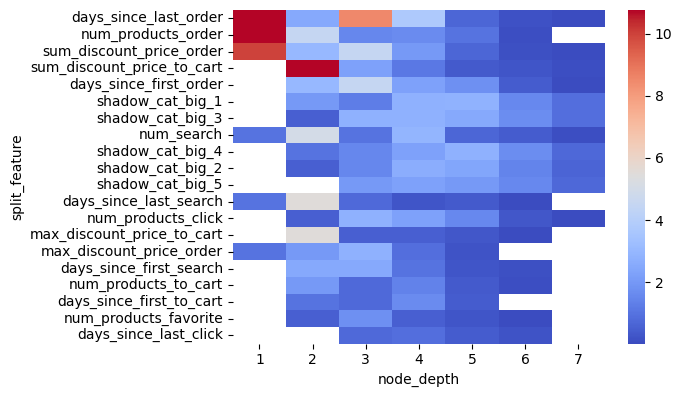

In [184]:
from warnings import filterwarnings
filterwarnings('ignore')

plot_feature_depth(t, top_k=20)

Вот такое участие фичей на разных уровнях. В очередной раз видим знакоые фичи в топе. Число дней с последнего и первого поиска не очень то важны и не очень используются, но мне кажется логичным, что если человек делал много поиска в последнее время, то он что то да купит. 

Нужно двигаться в сторону числа запросов за последний день\неделю\две недели\месяц. 

Еще одна схожая идея в том, что если человек закупает последнее время продукты одной группы или часто их смотри, то логично что он купит. Тут нужнеа кластеризация. 

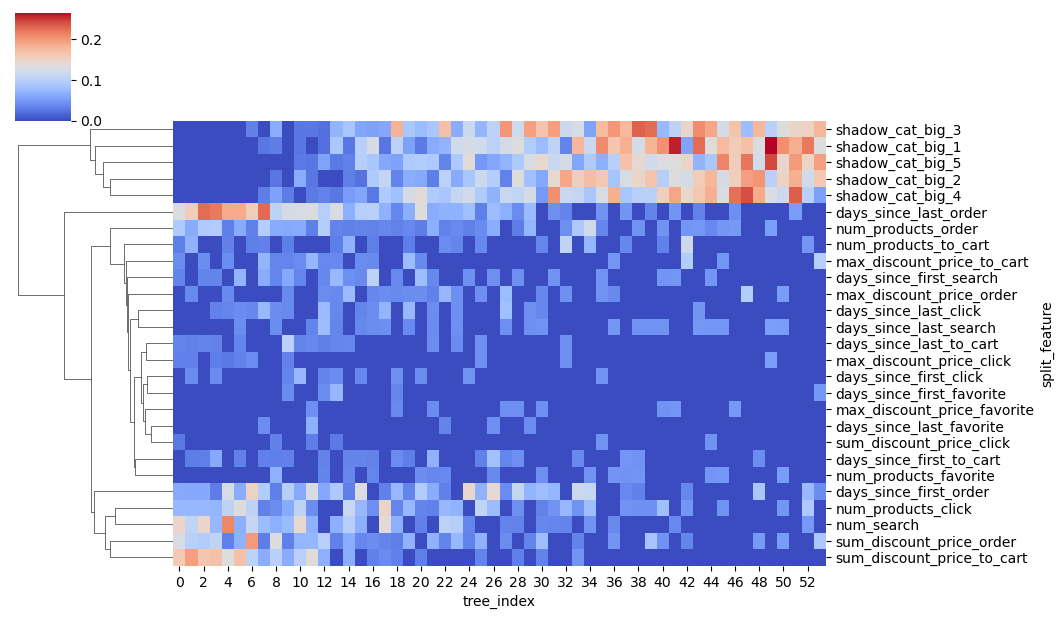

In [187]:
activations = plot_feature_info(t, top_k=30, return_activations=True)

6-ой признак это days since last order. Мусорные фичи после 20го дерева обретают силу, а значит после 20го дерева модель переобучается и начинает сходить с ума. Также последние фичи важные

In [189]:
activations.head(30)

tree_index                         0         1         2         3         4   \
split_feature                                                                   
days_since_first_click       0.000000  0.040278  0.000000  0.039925  0.000000   
days_since_first_favorite    0.000000  0.000000  0.000000  0.000000  0.000000   
days_since_first_order       0.062139  0.060835  0.061137  0.030514  0.125702   
days_since_first_search      0.035008  0.000000  0.034888  0.034733  0.000000   
days_since_first_to_cart     0.000000  0.030374  0.031205  0.062189  0.000000   
days_since_last_click        0.000000  0.000000  0.000000  0.033601  0.035514   
days_since_last_favorite     0.000000  0.000000  0.000000  0.000000  0.000000   
days_since_last_order        0.131528  0.155975  0.225173  0.219621  0.188042   
days_since_last_search       0.000000  0.000000  0.000000  0.000000  0.000000   
days_since_last_to_cart      0.034816  0.032934  0.034351  0.033844  0.000000   
max_discount_price_click     0.032887  0.032474  0.000000  0.031360  0.027626   
max_discount_price_favorite  0.000000  0.000000  0.000000  0.000000  0.000000   
max_discount_price_order     0.000000  0.038631  0.000000  0.000000  0.038577   
max_discount_price_to_cart   0.041292  0.000000  0.040960  0.000000  0.040664   
num_products_click           0.073907  0.074473  0.073691  0.071884  0.103929   
num_products_favorite        0.000000  0.000000  0.000000  0.000000  0.000000   
num_products_order           0.093260  0.062285  0.093138  0.095227  0.031519   
num_products_to_cart         0.032028  0.068704  0.000000  0.000000  0.032498   
num_search                   0.146068  0.107327  0.145267  0.073909  0.210711   
shadow_cat_big_1             0.000000  0.000000  0.000000  0.000000  0.000000   
shadow_cat_big_2             0.000000  0.000000  0.000000  0.000000  0.000000   
shadow_cat_big_3             0.000000  0.000000  0.000000  0.000000  0.000000   
shadow_cat_big_4             0.000000  0.000000  0.000000  0.000000  0.000000   
shadow_cat_big_5             0.000000  0.000000  0.000000  0.000000  0.000000   
sum_discount_price_click     0.027821  0.000000  0.000000  0.000000  0.000000   
sum_discount_price_order     0.128513  0.100155  0.095947  0.104839  0.032652   
sum_discount_price_to_cart   0.160732  0.195555  0.164242  0.168352  0.132567   

tree_index                         5         6         7         8         9   \
split_feature                                                                   
days_since_first_click       0.000000  0.000000  0.000000  0.000000  0.034951   
days_since_first_favorite    0.000000  0.000000  0.000000  0.000000  0.039947   
days_since_first_order       0.064241  0.151492  0.094844  0.031811  0.098097   
days_since_first_search      0.069672  0.000000  0.064007  0.035928  0.061219   
days_since_first_to_cart     0.032517  0.000000  0.033173  0.032044  0.032740   
days_since_last_click        0.039890  0.036521  0.075427  0.041051  0.039104   
days_since_last_favorite     0.000000  0.000000  0.040674  0.000000  0.000000   
days_since_last_order        0.187494  0.157646  0.227539  0.104450  0.125200   
days_since_last_search       0.040653  0.000000  0.000000  0.041073  0.000000   
days_since_last_to_cart      0.034375  0.000000  0.000000  0.000000  0.102408   
max_discount_price_click     0.032286  0.040341  0.000000  0.000000  0.033698   
max_discount_price_favorite  0.000000  0.000000  0.000000  0.000000  0.000000   
max_discount_price_order     0.000000  0.000000  0.000000  0.000000  0.038443   
max_discount_price_to_cart   0.000000  0.000000  0.070758  0.036145  0.036015   
num_products_click           0.134122  0.104043  0.033650  0.040272  0.062984   
num_products_favorite        0.000000  0.000000  0.000000  0.068958  0.000000   
num_products_order           0.062655  0.032959  0.097267  0.062243  0.061718   
num_products_to_cart         0.000000  0.031858  0.032664  0.000000  0.031877   
num_search                   0

Те фичи, у которых первые 5-7 колонок не нулевые очень важные, к ним стоит присмотреться и именно с ними стоит сроить новые комбинации. Хотя как я и сказал модель вполне стабильная и можно сделать полиномиальные фичи большой пачкой. 

In [197]:
%%time
import umap
from umap import UMAP

mapper = UMAP(n_jobs=16, n_neighbors=3, metric='euclidean', a=1, b=0.9, random_state=1)
emb = mapper.fit_transform(activations)

import plotly.express as px

embs = pd.DataFrame({
    'x': emb[:, 0],
    'y': emb[:, 1],
    'feature': activations.index,
    'color': activations.max(axis=1)
})
px.scatter(data_frame=embs, x='x', y='y', hover_data='feature', color='color')

CPU times: total: 4.33 s
Wall time: 4.61 s


In [ ]:
leaf_matrix = model_with_rnd.booster_.predict(tr_rnd[rnd_features], pred_leaf=True)
object_leaf_attr = extract_attr_by_leaf_matrix(t, leaf_matrix, 'count')
object_leaf_attr

Это эмбединги на обьектах, можно предсказать лист. Потом на них построим график.

In [205]:
n_objects = object_leaf_attr.shape[0]
sample_size = int(n_objects * 0.1)  # 10% от общего количества
print(f"Всего объектов: {n_objects}, будем использовать: {sample_size}")

Всего объектов: 1312469, будем использовать: 131246


In [209]:
import numpy as np
import pandas as pd
import umap
import plotly.express as px
import seaborn as sns

# Проверяем тип данных
print(f"Тип object_leaf_attr: {type(object_leaf_attr)}")

# Если это numpy array - преобразуем в DataFrame
if isinstance(object_leaf_attr, np.ndarray):
    object_leaf_attr = pd.DataFrame(object_leaf_attr)

# Получаем 10% случайной выборки
n_objects = len(object_leaf_attr)
sample_size = int(n_objects * 0.1)  # 10% выборка
print(f"Всего объектов: {n_objects}, выборка: {sample_size}")

Тип object_leaf_attr: <class 'pandas.core.frame.DataFrame'>
Всего объектов: 1312469, выборка: 131246


In [210]:

# Случайная выборка индексов
np.random.seed(1)
sample_indices = np.random.choice(object_leaf_attr.index, size=sample_size, replace=False)
sample_data = object_leaf_attr.loc[sample_indices]

# UMAP с автоматическим подбором n_neighbors
n_neighbors = min(30, sample_size//2)
mapper = umap.UMAP(
    n_neighbors=n_neighbors,
    metric='euclidean',
    random_state=1,
    n_jobs=16
)

In [211]:
emb = mapper.fit_transform(sample_data)


SystemError: CPUDispatcher(<function nn_descent at 0x000001E037117420>) returned a result with an exception set

In [ ]:
embs = pd.DataFrame({
    'x': emb[:, 0],
    'y': emb[:, 1],
    'color': np.median(sample_data, axis=1)
})
fig = px.scatter(embs, x='x', y='y', color='color')
fig.update_layout(width=800)
fig.show()

In [ ]:
'''%%time
mapper = umap.UMAP(n_jobs=16, n_neighbors=30, metric='euclidean', random_state=1)
emb = mapper.fit_transform(object_leaf_attr)

embs = pd.DataFrame({
    'x': emb[:, 0],
    'y': emb[:, 1],
    'color': np.median(object_leaf_attr, axis=1)
})
fig = px.scatter(data_frame=embs, x='x', y='y', color='color')
fig.update_layout(width=800)'''

Тип object_leaf_attr: <class 'numpy.ndarray'>
Всего объектов: 1312469, выборка: 131246


KeyboardInterrupt: 

In [ ]:
#sns.clustermap(object_leaf_attr, robust=True, col_cluster=False, cmap='coolwarm')
# y_raw_tr = model_with_rnd.predict(tr_rnd[rnd_features])
# idx = np.argsort(y_raw_tr)
# sns.heatmap(object_leaf_attr[idx], cmap='coolwarm')

In [202]:
import shap

explainer = shap.TreeExplainer(model_with_rnd)
shap_values = explainer(val_rnd[rnd_features])
print('features shape:', rnd_features.shape)

print('\n\nshap values structure:')
print('.values:', shap_values.values.shape, '.base_values:', shap_values.base_values.shape, '.data:', shap_values.data.shape)
shap_values # .values - shap values, .base_values - EF(X)=среднее_предсказание, .data - наши данные

features shape: (38,)


shap values structure:
.values: (562487, 38) .base_values: (562487,) .data: (562487, 38)


.values =
array([[-1.56426140e-01,  5.13762037e-04,  1.63492126e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.35237112e-02,  6.14167122e-03, -2.62936476e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.06145512e-02,  1.19494917e-04,  2.39725301e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 4.10333608e-02,  2.14120700e-03,  2.20534113e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.23297813e-02,  1.13483510e-03,  2.26771857e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.27530191e-02,  2.08583784e-03,  2.62007988e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

.base_values =
array([-0.68034305, -0.68034305, -0.68034305, ..., -0.68034305,
       -0.68034305, -0.68034305])

.data =
array([[20.0, 13833.0, 1868.0, ..., '0', '0', '0'],
       [1.0, 1094.0, 1094.0, ..., '2', '0', '2'],
       [

In [203]:
pretty_print(dir(shap_values))

['__add__', '__class__', '__copy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', 
	'__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', 
	'__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', 
	'__mul__', '__ne__', '__new__', '__radd__', '__reduce__', '__reduce_ex__', '__repr__', 
	'__rmul__', '__rsub__', '__setattr__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', 
	'__truediv__', '__weakref__', '_apply_binary_operator', '_flatten_feature_names', 
	'_numpy_func', '_s', '_use_data_as_feature_names', 'abs', 'argsort', 'base_values', 
	'clustering', 'cohorts', 'compute_time', 'data', 'display_data', 'error_std', 'feature_names', 
	'flip', 'hclust', 'hierarchical_values', 'hstack', 'identity', 'instance_names', 
	'lower_bounds', 'main_effects', 'max', 'mean', 'min', 'op_history', 'output_dims', 
	'output_indexes', 'output_names', 'percentile', 'sample', 'shape', 'sum', 'upper_bounds', 
	'values']


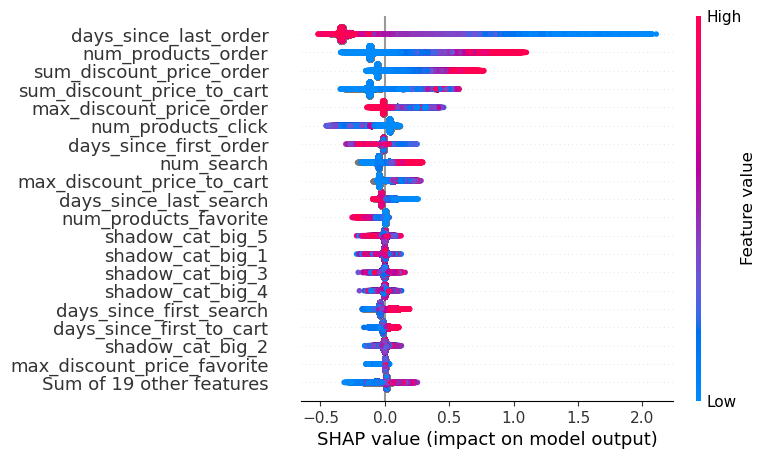

In [204]:
shap.plots.beeswarm(shap_values, max_display=20, order=shap.Explanation.abs.max(0), plot_size=(6, 5))

Мне кажется что число дней с последнего заказа не совсем адекватно, это было видно и на самых первых графиках. Если дней мало, то этот признак дество перетягивает таргет в сторону 1 и естественно начинает быть через чур сужественным в принятии решения. Хотя даже логически понятно, что если человек купил продукт вчера, то наверно в ближайшие дни он не купит ничего, он уже удовлетворил свою потребность, запишнув все в одну корзину, а если у него даже на следующий день появиться новая, то он ее отложит на потом. 


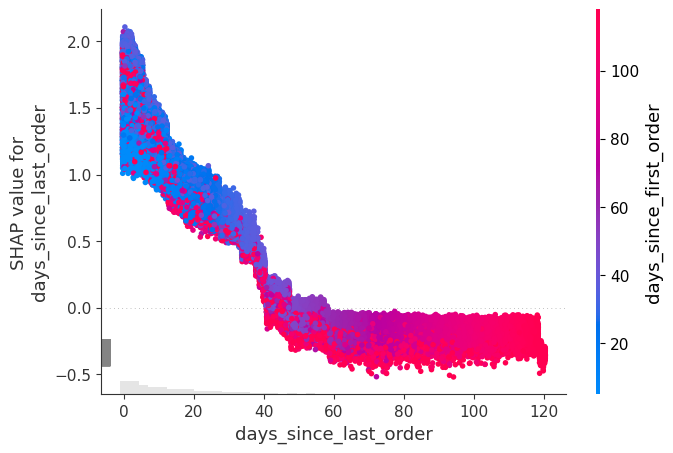

In [212]:
shap.plots.scatter(shap_values[:, 'days_since_last_order'], color=shap_values, x_jitter=0.7)

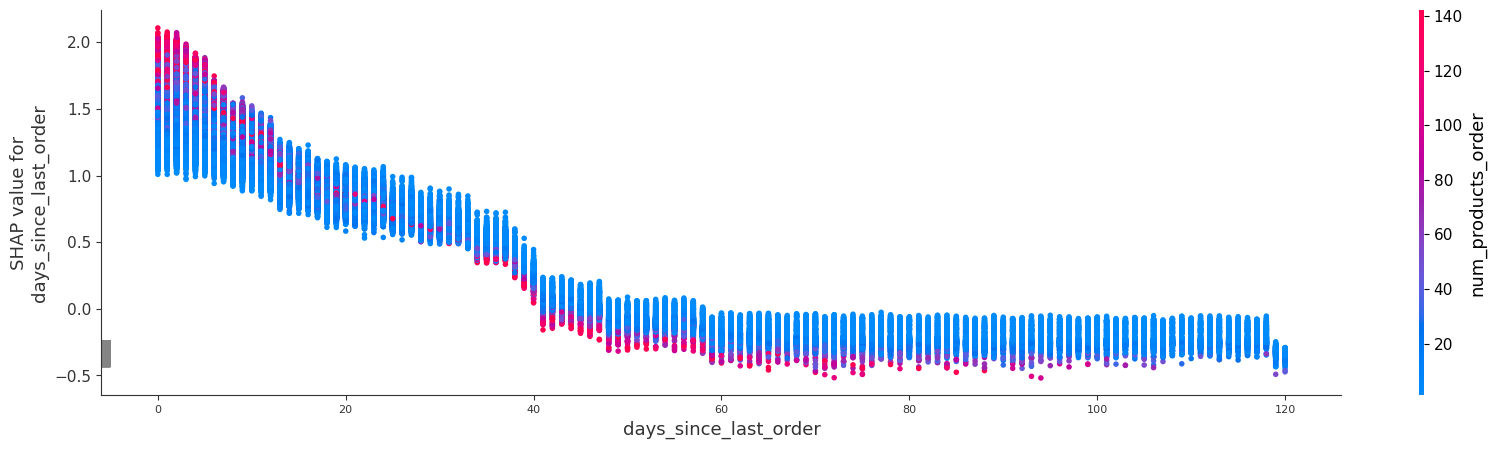

In [214]:
shap.dependence_plot('days_since_last_order', shap_values.values, features=val_rnd, interaction_index='num_products_order', show=False)
plt.gca().tick_params('x', labelsize=8)
plt.gcf().set_size_inches(20, 5)

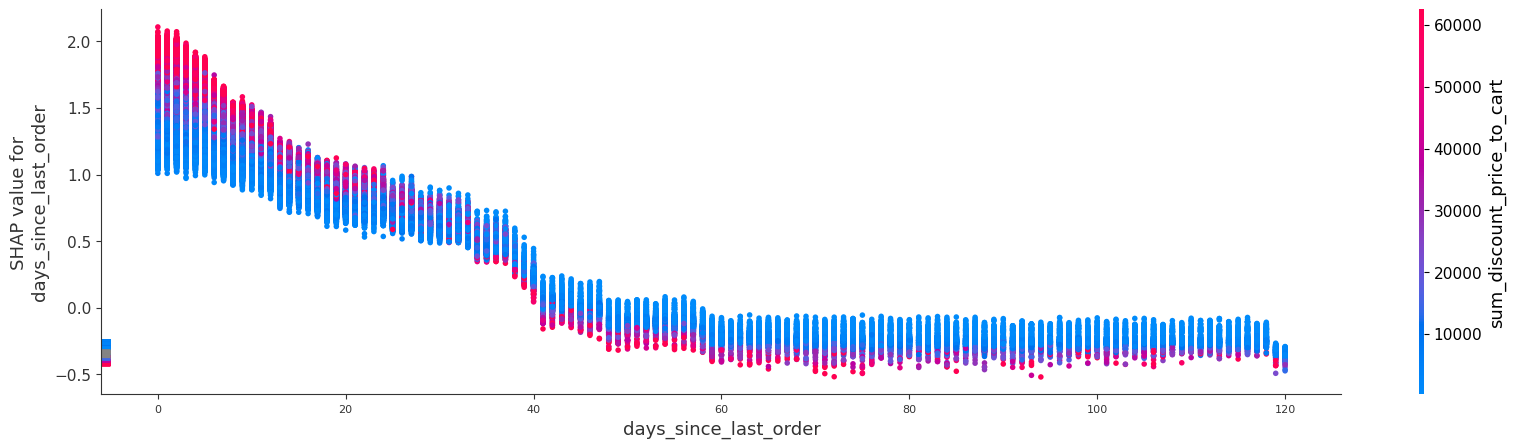

In [215]:
shap.dependence_plot('days_since_last_order', shap_values.values, features=val_rnd, interaction_index='sum_discount_price_to_cart', show=False)
plt.gca().tick_params('x', labelsize=8)
plt.gcf().set_size_inches(20, 5)

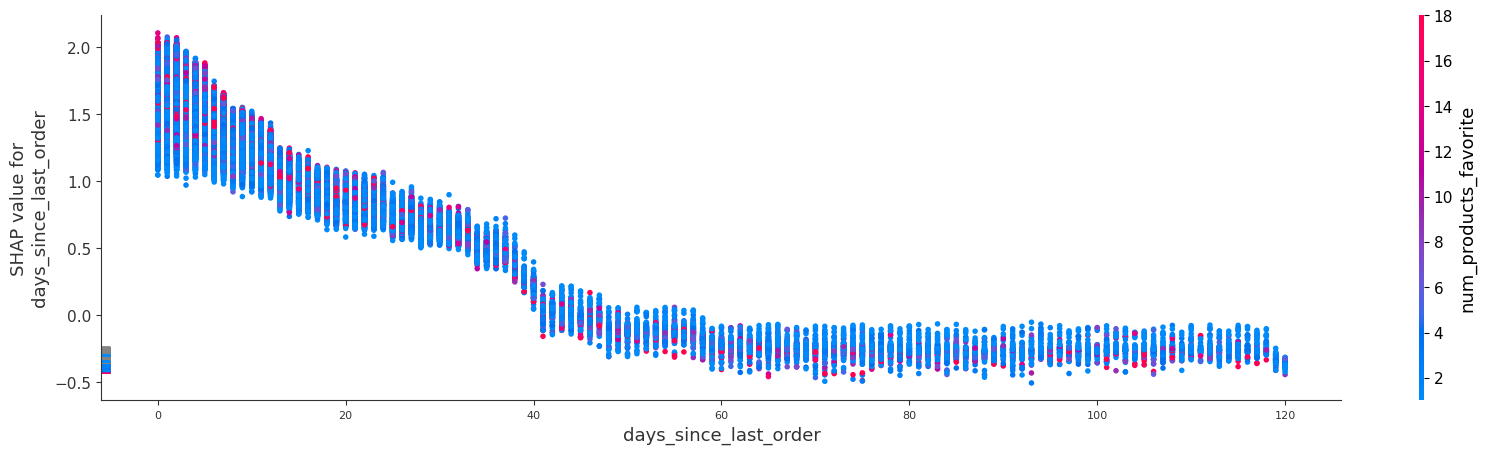

In [219]:
shap.dependence_plot('days_since_last_order', shap_values.values, features=val_rnd, interaction_index='num_products_favorite', show=False)
plt.gca().tick_params('x', labelsize=8)
plt.gcf().set_size_inches(20, 5)

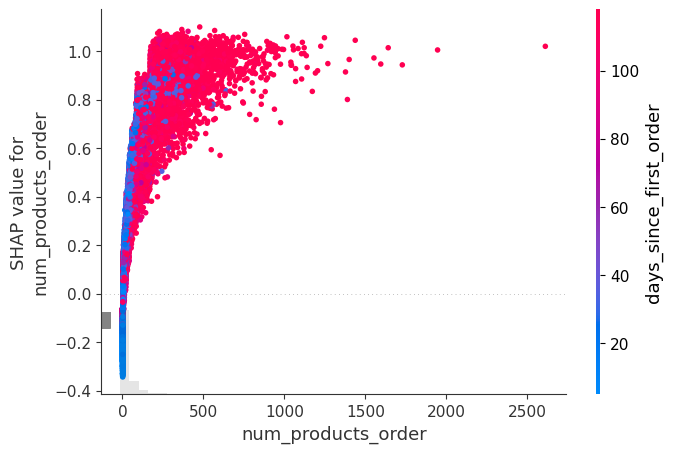

In [222]:
shap.plots.scatter(shap_values[:, 'num_products_order'], color=shap_values, x_jitter=0.7)

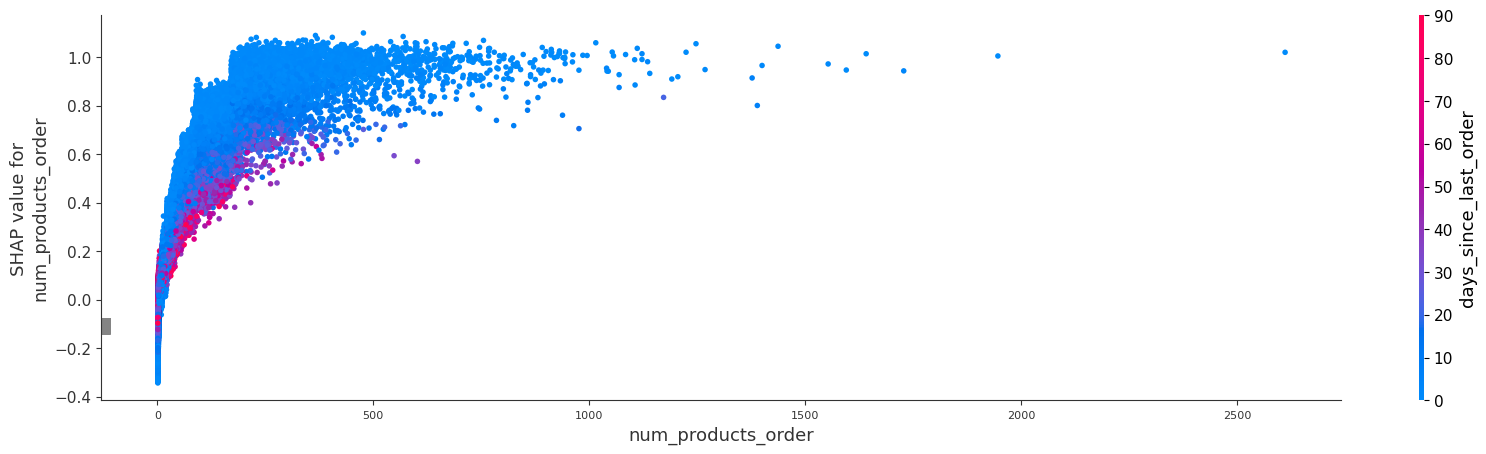

In [223]:
shap.dependence_plot('num_products_order', shap_values.values, features=val_rnd, interaction_index='days_since_last_order', show=False)
plt.gca().tick_params('x', labelsize=8)
plt.gcf().set_size_inches(20, 5)

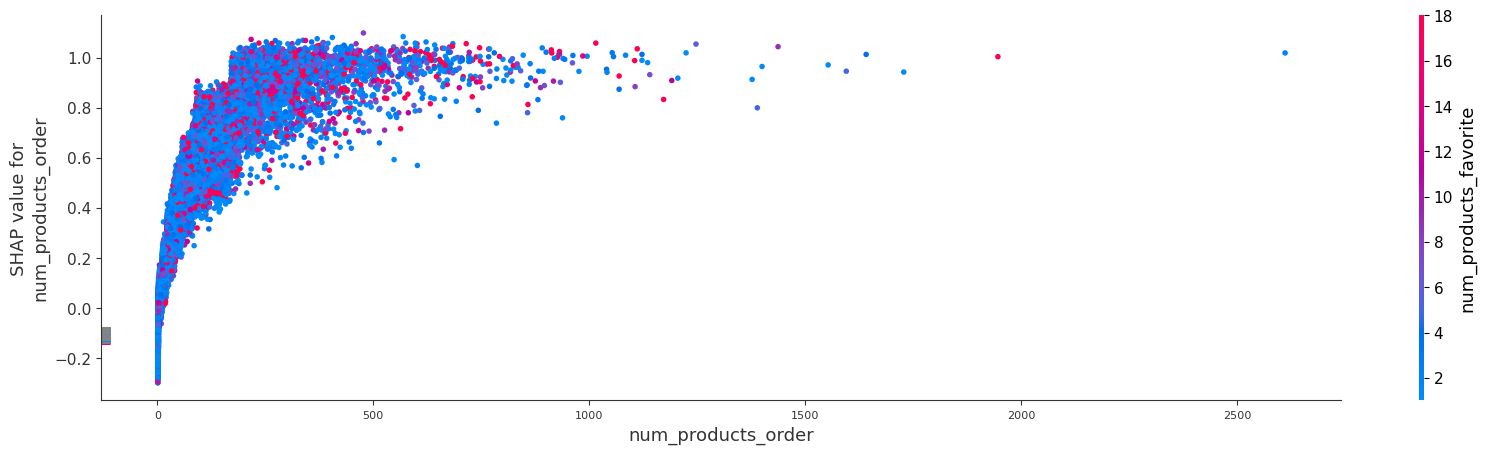

In [224]:
shap.dependence_plot('num_products_order', shap_values.values, features=val_rnd, interaction_index='num_products_favorite', show=False)
plt.gca().tick_params('x', labelsize=8)
plt.gcf().set_size_inches(20, 5)

In [226]:
shap.initjs()
shap.plots.force(shap_values[:300])

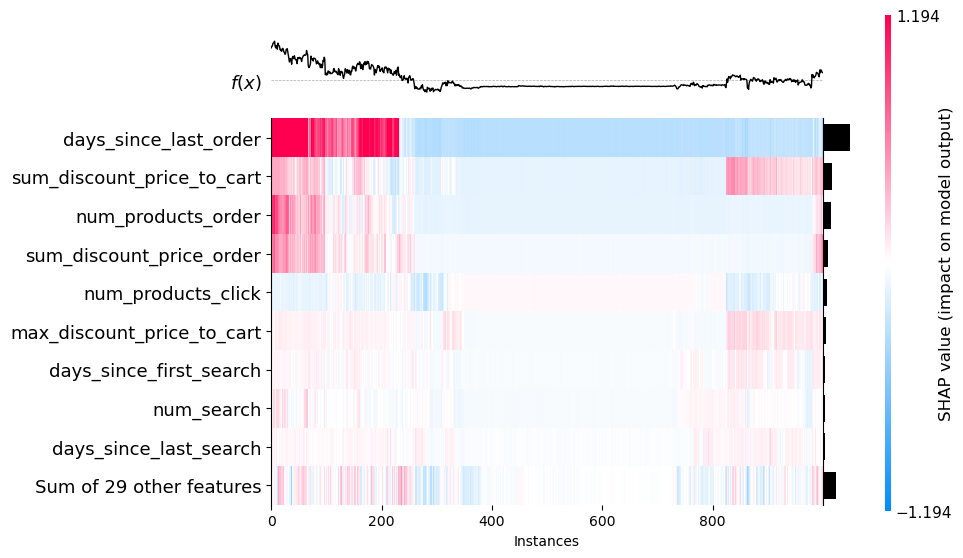

<Axes: xlabel='Instances'>

In [225]:
shap.plots.heatmap(shap_values[:1000])

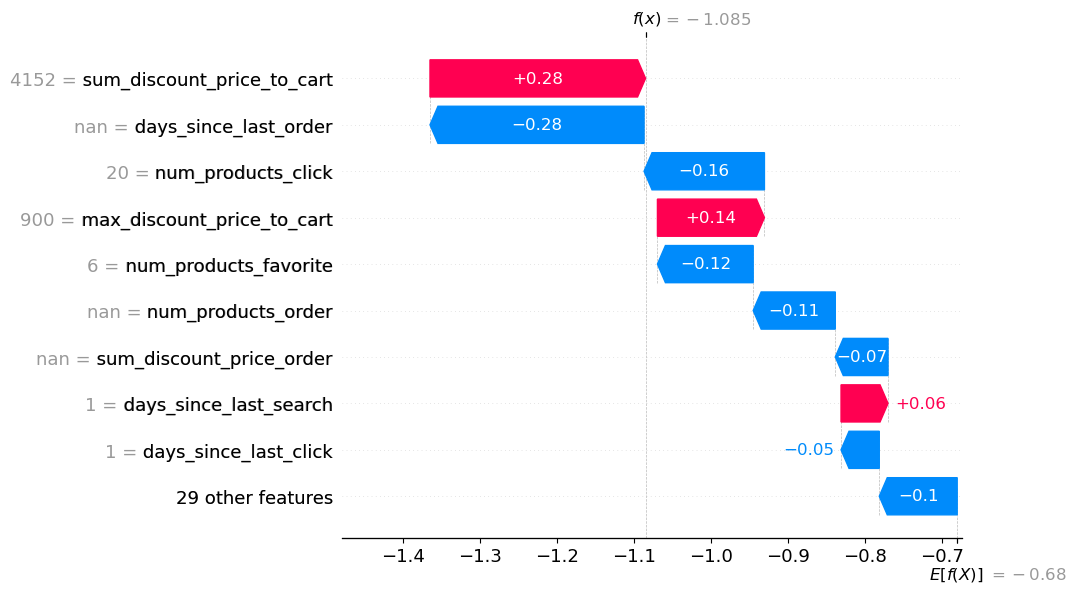

In [227]:
shap.plots.waterfall(shap_values[0])

In [230]:
%%time
from local_utils import *
import catboost as cb

explainer = shap.TreeExplainer(model_cb)
val_pool = cb.Pool(val_rnd[rnd_features], val.target, cat_features=val_rnd[rnd_features].select_dtypes('category').columns.to_list())
shap_interaction_values = explainer.shap_interaction_values(val_pool)
print(shap_interaction_values.shape)
shap_interaction_values[:2]

(562487, 38, 38)
CPU times: total: 56min 4s
Wall time: 6min 23s


array([[[-3.69531236e-02,  4.82863936e-05,  5.10661686e-04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 4.82863936e-05,  2.00380084e-02,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 5.10661686e-04,  0.00000000e+00,  8.44008412e-03, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-4.31956635e-02,  4.79408779e-05,  2.77050218e-04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 4.79408779e-05, -1.18983129e-02,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e

<Figure size 640x480 with 0 Axes>

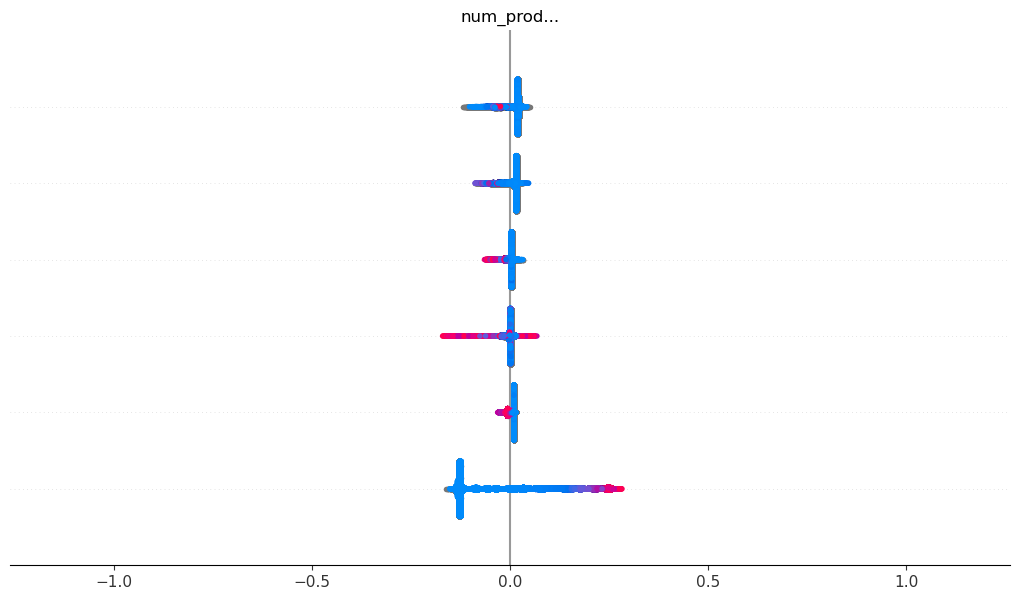

In [ ]:
shap.summary_plot(shap_interaction_values, max_display=6, features=val_rnd)

# Данные и их анализ
Теперь нужно оценить данные на выбросы и пропуски.

Возможно следовало сделать это с самого начала, но мне кажется, что после понимания того, какие есть слабые места у модели, оценить данные на пропуски получится лучше.

In [60]:
import polars as pl
import pandas as pd
import numpy as np
import catboost
import os
from datetime import date, timedelta
from local_utils import *
import lightgbm as lgb

%load_ext autoreload
%autoreload 2

test_start_date = date(2024, 8, 1)
val_start_date = date(2024, 7, 1)
val_end_date = date(2024, 7, 31)
train_end_date = date(2024, 6, 30)
data_path = "C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet')).collect()
search_history = pl.scan_parquet(os.path.join(data_path, 'search_history/*.parquet')).collect()
product_information = pl.read_csv(
    os.path.join(data_path, 'product_information.csv'),
    ignore_errors=True
)

val_target = (
    actions_history
    .filter(pl.col('timestamp').dt.date() >= val_start_date)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .select('user_id', (pl.col('action_type_id') == 3).alias('has_order'))
    .group_by('user_id')
    .agg(pl.max('has_order').cast(pl.Int32).alias('target'))
)

In [62]:
act_analyse = actions_history.to_pandas()

In [63]:
build_my_info_table(act_analyse)

KeyboardInterrupt: 

In [64]:
val_target.group_by('target').agg(pl.count('user_id'))

shape: (2, 2)
┌────────┬─────────┐
│ target ┆ user_id │
│ ---    ┆ ---     │
│ i32    ┆ u32     │
╞════════╪═════════╡
│ 0      ┆ 1227381 │
│ 1      ┆ 647575  │
└────────┴─────────┘

In [65]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite",
    3: "order",
    5: "to_cart",
}
for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 4))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information
            .select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
        .select(
            'user_id',
            f'num_products_{suf}',
            f'sum_discount_price_{suf}',
            f'max_discount_price_{suf}',
            f'days_since_last_{suf}',
            f'days_since_first_{suf}',
        )
    )
    actions_aggs[id_] = aggs
# search_aggs
id_ = 4
suf = 'search'
actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 4))
    .group_by('user_id')
    .agg(
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .with_columns([
        (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
        .dt.total_days()
        .cast(pl.Int32)
        .alias(f'days_since_last_{suf}'),

        (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
        .dt.total_days()
        .cast(pl.Int32)
        .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    )
)

In [66]:
df = val_target
for _, actions_aggs_df in actions_aggs.items():
    df = (
        df
        .join(actions_aggs_df, on='user_id', how='left')
    )

In [67]:
df_topd = df.to_pandas()

In [21]:
df_topd.columns

Index(['user_id', 'target', 'num_products_click', 'sum_discount_price_click',
       'max_discount_price_click', 'days_since_last_click',
       'days_since_first_click', 'num_products_favorite',
       'sum_discount_price_favorite', 'max_discount_price_favorite',
       'days_since_last_favorite', 'days_since_first_favorite',
       'num_products_order', 'sum_discount_price_order',
       'max_discount_price_order', 'days_since_last_order',
       'days_since_first_order', 'num_products_to_cart',
       'sum_discount_price_to_cart', 'max_discount_price_to_cart',
       'days_since_last_to_cart', 'days_since_first_to_cart', 'num_search',
       'days_since_last_search', 'days_since_first_search'],
      dtype='object')

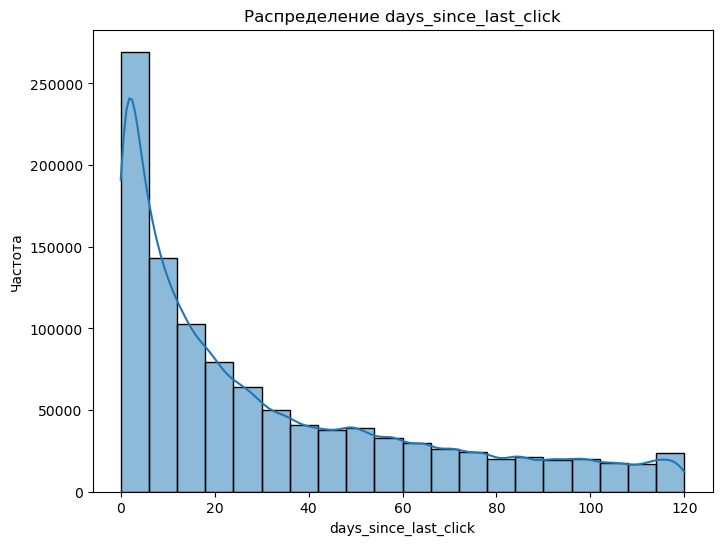

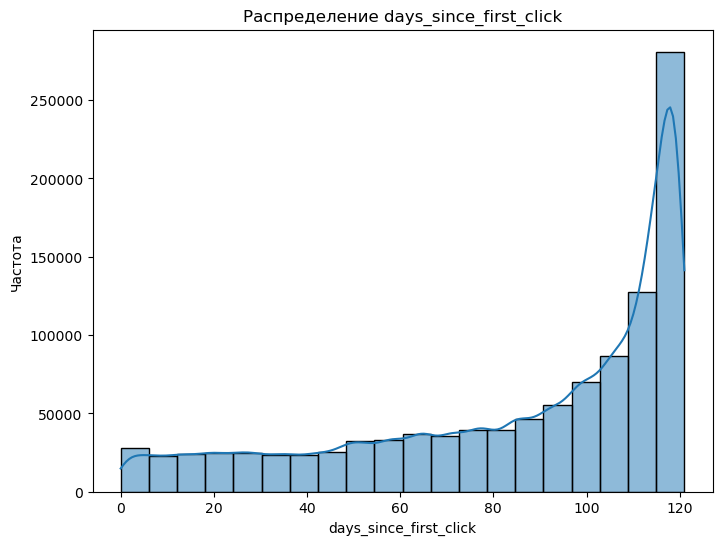

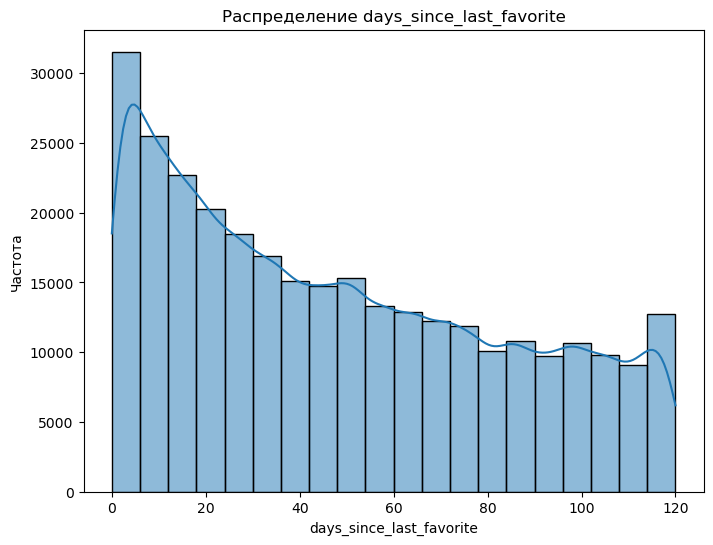

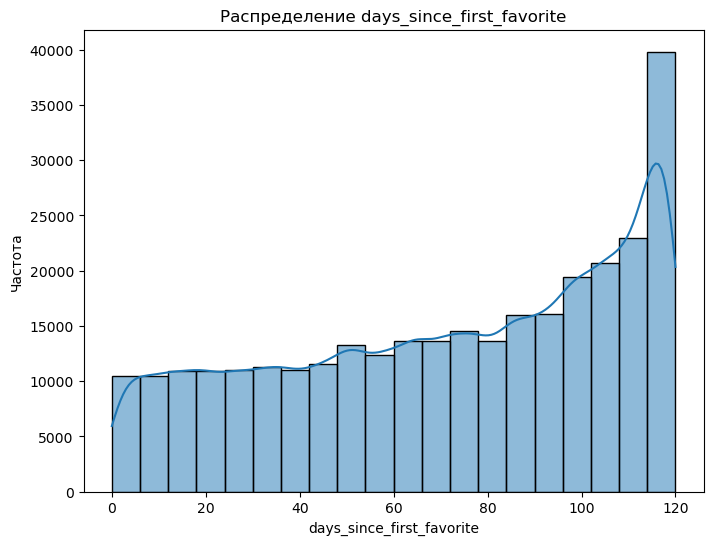

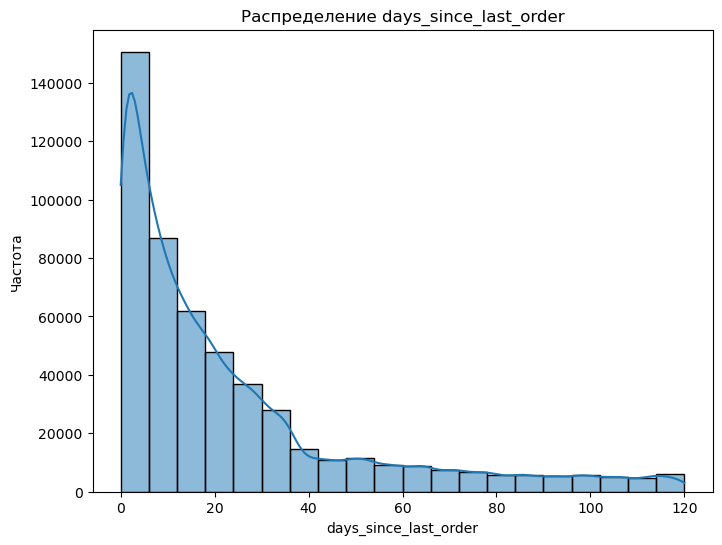

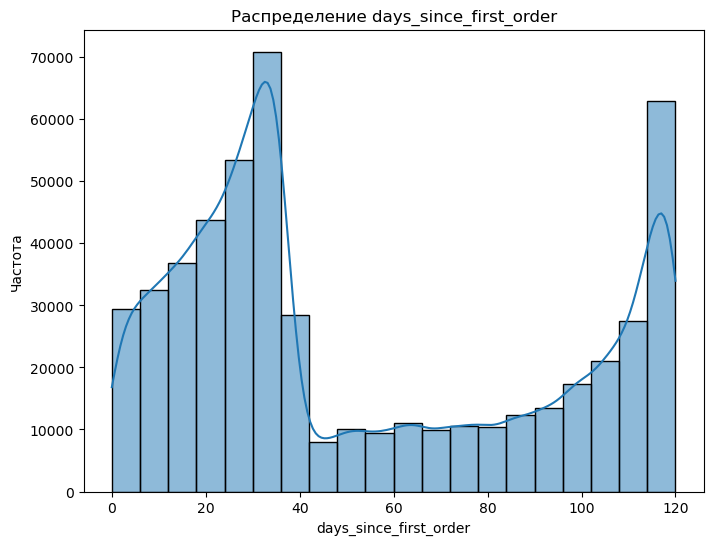

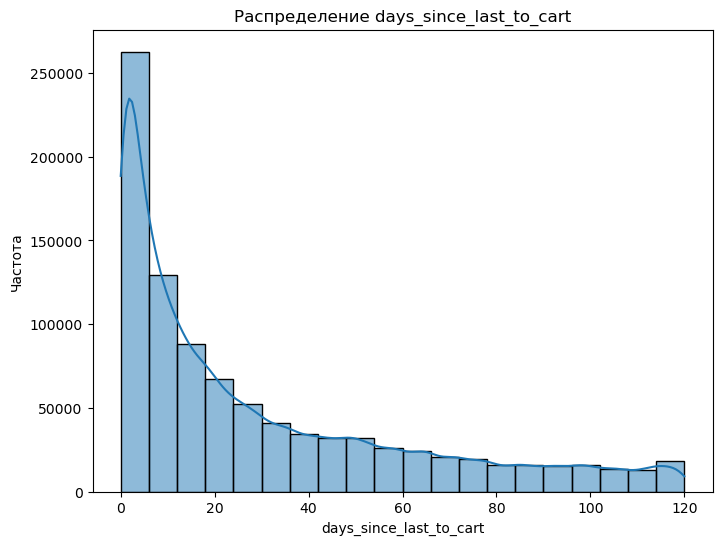

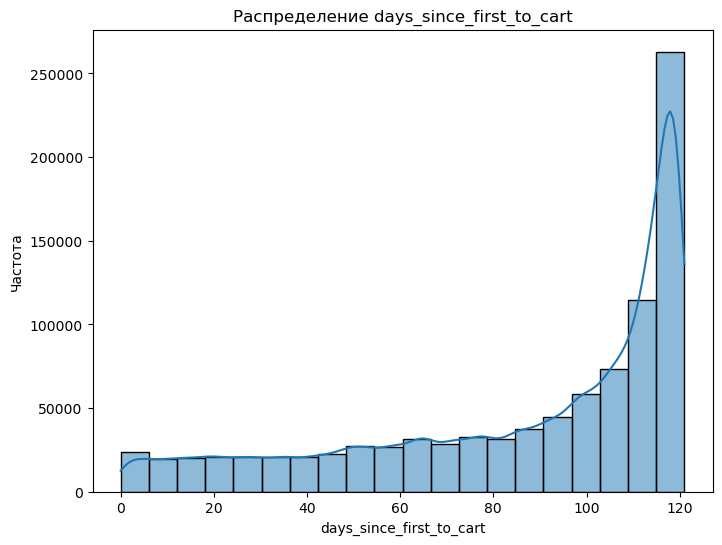

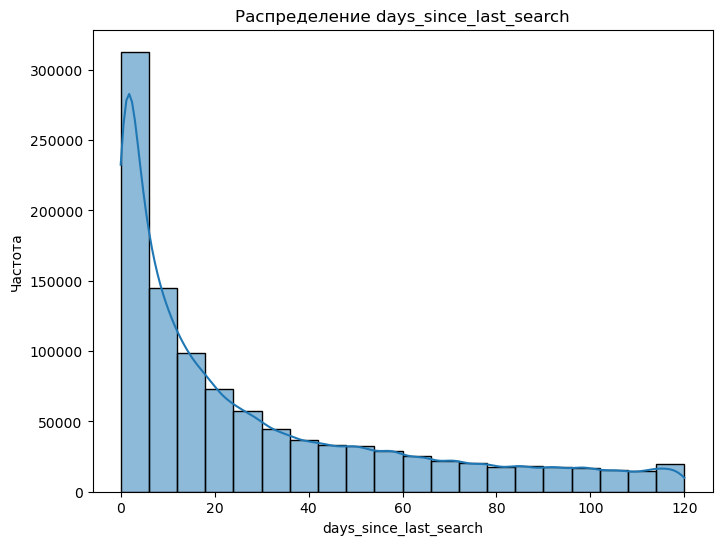

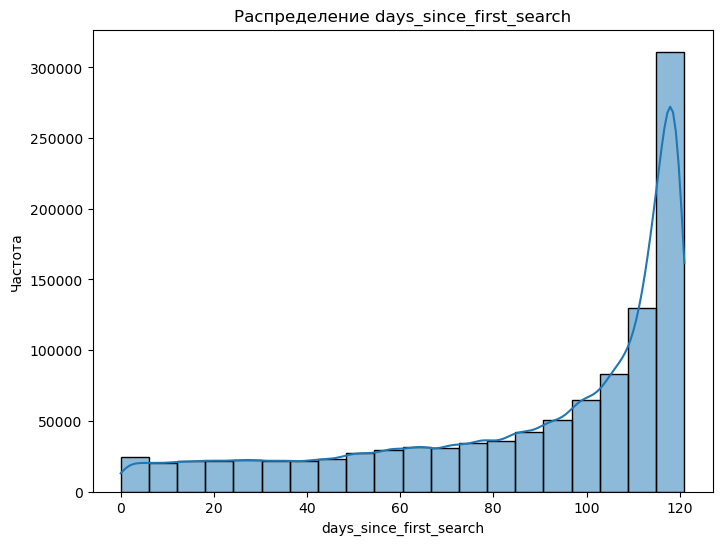

In [23]:
cols = ['days_since_last_click',
       'days_since_first_click', 'days_since_last_favorite', 'days_since_first_favorite', 'days_since_last_order',
       'days_since_first_order', 'days_since_last_to_cart', 'days_since_first_to_cart', 'days_since_last_search', 'days_since_first_search']

for col in cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(df_topd[col], bins=20, kde=True)
    plt.title(f'Распределение {col}')
    plt.xlabel(f'{col}')
    plt.ylabel('Частота')
    plt.show()

In [ ]:
from IPython.display import display

display(get_df_info_new(df_topd).style.bar(subset=['nunique'], cmap="bwr"))

In [68]:
print('-----------------------------------------')
build_my_info_table(df_topd)

-----------------------------------------


#                       column    dtype    count          mean  \
0    0                      user_id    int32  1874956     5592273.4   
1    1                       target    int32  1874956                 
2    3     sum_discount_price_click  float32  1078331       26127.5   
3    4     max_discount_price_click  float32  1077493   3374.800049   
4   19   max_discount_price_to_cart  float32   936232   1539.800049   
5    8  sum_discount_price_favorite  float32   303496   5117.399902   
6    9  max_discount_price_favorite  float32   303112   1645.300049   
7   18   sum_discount_price_to_cart  float32   936548  15116.299805   
8   13     sum_discount_price_order  float32   518975   8116.200195   
9   14     max_discount_price_order  float32   518829   1291.800049   
10  22                   num_search  float64  1046516          43.4   
11  21     days_since_first_to_cart  float64   936548          86.3   
12  20      days_since_last_to_cart  float64   936548          29.6   
13  17         num_products_to_cart  float64   936548          54.1   
14  16       days_since_first_order  float64   518975          53.2   
15  12           num_products_order  float64   518975          34.7   
16  23       days_since_last_search  float64  1046516          28.6   
17  11    days_since_first_favorite  float64   303496          71.1   
18  10     days_since_last_favorite  float64   303496          48.0   
19   7        num_products_favorite  float64   303496           6.6   
20   6       days_since_first_click  float64  1078331          85.3   
21   5        days_since_last_click  float64  1078331          31.9   
22   2           num_products_click  float64  1078331          35.1   
23  15        days_since_last_order  float64   518975          23.5   
24  24      days_since_first_search  float64  1046516          87.9   

          std   min        25%        50%        75%           95%  \
0   3228861.6    12  2797435.2  5589704.5  8388595.0    10628814.2   
1                                                                    
2   5460127.0   0.0     1452.0     5695.0    19243.0       83159.0   
3      8738.4   5.0      580.0     1280.0     2780.0       12770.0   
4      3663.6  12.0      425.0      853.0     1586.0        4011.0   
5    663393.8   0.0      345.0      977.0     2902.0       14696.0   
6      4711.7  12.0      270.0      599.0     1397.0        5524.0   
7    148998.2   0.0     1258.0     4862.0    16276.0  62814.300781   
8     14604.5   0.0     1339.0     3322.0     8664.0  31426.300781   
9      2344.1   9.0      445.0      799.0     1440.0        3390.0   
10     2282.5   0.0        4.0       12.0       43.0         180.0   
11       34.9   0.0       63.0      101.0      115.0         120.0   
12       31.9   0.0        5.0       17.0       47.0         101.0   
13      315.0   1.0        4.0       15.0       56.0         240.0   
14       39.5   0.0       22.0       35.0       95.0         118.0   
15       67.2   1.0        4.0       12.0       35.0         143.0   
16       31.8   0.0        4.0       15.0       45.0         100.0   
17       36.0   0.0       41.0       76.0      104.0         118.0   
18       35.4   0.0       16.0       42.0       76.0         112.0   
19      594.1   1.0        1.0        2.0        4.0          19.0   
20       34.8   0.0       62.0       99.0      115.0         120.0   
21       32.7   0.0        6.0       19.0       51.0         103.0   
22     2936.7   1.0        3.0       10.0       34.0         134.0   
23       27.4   0.0        4.0       13.0       31.0          90.0   
24       34.4   0.0       66.0      103.0      116.0         120.0   

             max           IQR  nunique  unique   mode   mode #  mode %  \
0       11184165      11184153  1874956           12.0        1     0.0   
1                                     2  [0, 1]    0.0  1227381    65.5   
2   5669538304.0  5669538304.0   120445          399.0     1421     0.1   
3       850000.0      849995.0     93

Тут нас интересуют выбросы, то есть колонки у которых 95% очень сильно отличается от максимального значения. 

Логично, что все фичи про число дней не имеют такиз выбросов, а вот агрегационные наоборот.


In [117]:
df_topd[df_topd['sum_discount_price_favorite'] >= 10_000_000]

user_id  target  num_products_click  sum_discount_price_click  \
1261747  2346229       0           3048760.0              5.669538e+09   

         max_discount_price_click  days_since_last_click  \
1261747                  183990.0                    0.0   

         days_since_first_click  num_products_favorite  \
1261747                   120.0               327096.0   

         sum_discount_price_favorite  max_discount_price_favorite  ...  \
1261747                  365258976.0                     167590.0  ...   

         days_since_last_order  days_since_first_order  num_products_to_cart  \
1261747                    NaN                     NaN              288085.0   

         sum_discount_price_to_cart  max_discount_price_to_cart  \
1261747                 141003648.0                    167590.0   

         days_since_last_to_cart  days_since_first_to_cart  num_search  \
1261747                      0.0                     120.0   2333559.0   

         days_since_last_search  days_since_first_search  
1261747                     0.0                    120.0  

[1 rows x 25 columns]

In [ ]:
#Какой то жутко избыточный подход, неадекватныч только один - 2346229

h_sum_discount_price_click = df_topd.loc[df_topd['sum_discount_price_click'] >= 100_000_000, 'user_id'].tolist()
h_sum_discount_price_favorite = df_topd.loc[df_topd['sum_discount_price_favorite'] >= 10_000_000, 'user_id'].tolist()
h_num_search = df_topd.loc[df_topd['num_search'] >= 10_000, 'user_id'].tolist()
h_num_products_to_cart = df_topd.loc[df_topd['num_products_to_cart'] >= 10_000, 'user_id'].tolist()
h_num_products_favorite = df_topd.loc[df_topd['num_products_favorite'] >= 10_000, 'user_id'].tolist()
h_num_products_click = df_topd.loc[df_topd['num_products_click'] >= 20_000, 'user_id'].tolist()

res = [set(h_sum_discount_price_click + h_sum_discount_price_favorite + h_num_search + h_num_products_to_cart + h_num_products_favorite + h_num_products_click)]
res

[{2346229}]

In [123]:
df_topd = df_topd[df_topd['user_id'] != 2346229]

In [124]:
build_my_info_table(df_topd)

#                       column    dtype    count          mean  \
0    0                      user_id    int32  1874955     5592275.1   
1    1                       target    int32  1874955                 
2    3     sum_discount_price_click  float32  1078330  20869.800781   
3    4     max_discount_price_click  float32  1077492   3374.600098   
4   19   max_discount_price_to_cart  float32   936231   1539.599976   
5    8  sum_discount_price_favorite  float32   303495        3914.0   
6    9  max_discount_price_favorite  float32   303111   1644.699951   
7   18   sum_discount_price_to_cart  float32   936547  14965.700195   
8   13     sum_discount_price_order  float32   518975   8116.200195   
9   14     max_discount_price_order  float32   518829   1291.800049   
10  22                   num_search  float64  1046515          41.2   
11  21     days_since_first_to_cart  float64   936547          86.3   
12  20      days_since_last_to_cart  float64   936547          29.6   
13  17         num_products_to_cart  float64   936547          53.7   
14  16       days_since_first_order  float64   518975          53.2   
15  12           num_products_order  float64   518975          34.7   
16  23       days_since_last_search  float64  1046515          28.6   
17  11    days_since_first_favorite  float64   303495          71.1   
18  10     days_since_last_favorite  float64   303495          48.0   
19   7        num_products_favorite  float64   303495           5.5   
20   6       days_since_first_click  float64  1078330          85.3   
21   5        days_since_last_click  float64  1078330          31.9   
22   2           num_products_click  float64  1078330          32.3   
23  15        days_since_last_order  float64   518975          23.5   
24  24      days_since_first_search  float64  1046515          87.9   

          std   min        25%        50%        75%           95%  \
0   3228861.6    12  2797439.5  5589706.0  8388596.0    10628814.7   
1                                                                    
2     71971.5   0.0     1452.0     5695.0    19243.0  83157.601562   
3      8736.7   5.0      580.0     1280.0     2780.0       12770.0   
4      3659.6  12.0      425.0      853.0     1586.0        4011.0   
5     22887.1   0.0      345.0      977.0     2902.0  14694.599609   
6      4702.0  12.0      270.0      599.0     1397.0        5524.0   
7     31908.3   0.0     1258.0     4862.0    16276.0  62812.699219   
8     14604.5   0.0     1339.0     3322.0     8664.0  31426.300781   
9      2344.1   9.0      445.0      799.0     1440.0        3390.0   
10       79.9   0.0        4.0       12.0       43.0         180.0   
11       34.9   0.0       63.0      101.0      115.0         120.0   
12       31.9   0.0        5.0       17.0       47.0         101.0   
13      103.2   1.0        4.0       15.0       56.0         240.0   
14       39.5   0.0       22.0       35.0       95.0         118.0   
15       67.2   1.0        4.0       12.0       35.0         143.0   
16       31.8   0.0        4.0       15.0       45.0         100.0   
17       36.0   0.0       41.0       76.0      104.0         118.0   
18       35.4   0.0       16.0       42.0       76.0         112.0   
19       22.1   1.0        1.0        2.0        4.0          19.0   
20       34.8   0.0       62.0       99.0      115.0         120.0   
21       32.7   0.0        6.0       19.0       51.0         103.0   
22       68.5   1.0        3.0       10.0       34.0         134.0   
23       27.4   0.0        4.0       13.0       31.0          90.0   
24       34.4   0.0       66.0      103.0      116.0         120.0   

           max         IQR  nunique  unique   mode   mode #  mode %   null #  \
0     11184165    11184153  1874955           12.0        1     0.0        0   
1                                 2  [0, 1]    0.0  1227380    65.5        0   
2   17232244.0  17232244.0   120444          399.0     1421     0.1   796625   
3     850000.0   

Ситуация стала слегка адекватнее, не хочу сильно дропать строки, потмоу что чел с немного аномальным значением может оказаться просто очень активным покупателем, так что он не выброс, а наоборот, ценный экземпляр. 